# Introducción

En esta libreta de Jupyter se encuentra desglosado en código todo lo realizado y presentado para el trabajo escrito. Se respeta la enumeración que se lleva en el documento escrito.

# 0. Código 

Esta sección contiene las diferentes funciones y código que se usará a lo largo del proyecto

## 0.1 Importar Librerías y Funciones Varias

In [1]:
# Importar librerías

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

In [2]:
# Funcionalidades para Tipado

from typing import Callable

In [76]:
# Definiendo variables y constantes

Color_Palette = ['green','red','gold']
Color_Map = 'seismic'

Macronutrients = ['Carbs','Protein','Fat']
Diets = ['dash', 'keto', 'mediterranean', 'paleo', 'vegan']
Cuisine = 'Cuisine_type'
Diet = 'Diet_type'

MapTranslate = {
    'Carbs' : 'Carbohidratos',
    'Protein' : 'Proteínas',
    'Fat' : 'Grasas',
}

In [72]:
def __CreateMosaicPlot():
    """
        Function for creating the fig
        for plots
    """
    Display = "PPCC\n.FF."

    fig , axes = plt.subplot_mosaic(Display,figsize=(12,8),layout='tight',subplot_kw={'xlim':(0-1e-2,1+1e-2)})
    ConfigPlot = zip(Macronutrients,['C','P','F'],Color_Palette)

    return fig , axes , ConfigPlot

def __OrderDiets(Dataset:pd.DataFrame,Macronutrient:str) -> np.ndarray:
    return Dataset[Macronutrient].quantile(0.25).sort_values().index

def __SetLabelsPlot(ax,Title:str,XLabel:str=None,YLabel:str=None) -> None:
    ax.set_title(Title,size=18)
    if XLabel : ax.set_xlabel(XLabel,size=14)
    if YLabel : ax.set_ylabel(YLabel,size=14)
    ax.tick_params(labelsize=12)

def __SetTitleFig(fig,Title:str) -> None:
    fig.suptitle(Title,size=30)

In [5]:
def Plot_DistributionMacronutrients(Diets_Dataset:pd.DataFrame):
    """
        Función para gráficar los gráficos de tipo cajas y bigotes 
        por cada macronutriente.
    """
    fig , axes , ConfigPlot = __CreateMosaicPlot()
    for macronutrient , display , color in ConfigPlot:
        sns.boxplot(data=Diets_Dataset,x=macronutrient,ax=axes[display],color=color)
        __SetLabelsPlot(axes[display],MapTranslate[macronutrient],'Porcentaje de Gramos')

    __SetTitleFig(fig,'Distribución de Macronutrientes')

    return fig

In [6]:
def Plot_MacronutientsByDiet_Histogram(Diets_Dataset:pd.DataFrame,Diet:str) -> None:
    """
        Función para gráficar los histogramas de los macronutrientes 
        para dieta en específico.
    """
    diet_type_dataset = Diets_Dataset.query("Diet_type == @Diet")
    def PlotMacronutients():
        fig , axes , ConfigPlot = __CreateMosaicPlot()
        for macronutrient , display , color in ConfigPlot:
            sns.histplot(data=diet_type_dataset,x=macronutrient,ax=axes[display],stat='proportion',bins=25,color=color)
            __SetLabelsPlot(axes[display],MapTranslate[macronutrient],'Porcentaje de Gramos','Proporción')

        __SetTitleFig(fig,f'Dieta: {Diet}')

    PlotMacronutients()

In [77]:
def Plot_MacronutrientsByDiet_Boxplot(Diets_Dataset:pd.DataFrame,Macronutrients:list[str]) -> None:
    """
        Función para gráficar las boxplots de los macronutrientes por 
        dieta.
    """
    fig , axes , ConfigPlot = __CreateMosaicPlot()
    for macronutrient , display , color in ConfigPlot:
        order_diets = __OrderDiets(Diets_Dataset.groupby(Diet),macronutrient)
        sns.boxplot(data=Diets_Dataset,x=macronutrient,y='Diet_type',ax=axes[display],color=color,order=order_diets)
        __SetLabelsPlot(axes[display],MapTranslate[macronutrient],'Porcentaje de Gramos','Tipo de Dieta')
    
    __SetTitleFig(fig,'Distribución de Macronutrientes por Dieta')

In [8]:
def SummaryMeasures(Dataset_Sample:pd.DataFrame,Features:list[str]) -> pd.DataFrame:
    """
        Función para calcular la media, Q1, Q2, Q3, desviación 
        estándar, mínimo, máximo y asimetría de Fisher de un 
        conjunto de datos sobre ciertos atributos
    """
    measures = ['mean','25%','50%','75%','std','min','max']
    
    summary_measures = Dataset_Sample[Features].describe().loc[measures]
    summary_measures.loc['skewness'] = Dataset_Sample[Features].skew()

    return summary_measures

In [9]:
def Frequencies_Sample(Sample:pd.DataFrame,Variable:str) -> pd.DataFrame:
    """
        Función para obtener las frecuencias relativas, absoluta y acumulada 
        de una muestra en base a un atributo/variable continua. 
    """
    frequency_absolute , bins_classes = np.histogram(Sample[Variable],bins=7)

    frequency_random = []
    frequency_random.append(frequency_absolute)
    frequency_random.append(frequency_absolute/50)
    frequency_random.append(np.cumulative_sum(frequency_absolute)/50)

    class_marks = (bins_classes[:-1]+bins_classes[1:])/2
    
    sampling_mean = Sample[Variable].mean()
    sampling_std = Sample[Variable].std()
    frequency_random.append((class_marks-sampling_mean)/sampling_std)

    frequency_random = pd.DataFrame(frequency_random,index=['Frequency_absolute','Frequency_relative','Frequency_cumulative','Z-Score'],columns=class_marks).T
    frequency_random.rename_axis(index='Class_mark',columns='Frequencies',inplace=True)

    return frequency_random

In [10]:
def ZScores_Sample(Sample:pd.DataFrame,Variable:str) -> pd.DataFrame:
    """
        Función para determinar los puntajes Z de cada valor 
        perteneciente a una muestra.
    """
    values = Sample[Variable]
    z_scores = (values-values.mean())/values.std()

    summary_data = pd.concat([values,z_scores],ignore_index=True,axis=1)
    summary_data.rename(columns=dict(zip(range(2),['Value','ZScore'])),inplace=True)
    return summary_data

In [11]:
def Show_ConfidenceIntervals(Data_Sample:np.ndarray,ConfidenceLevels:list[float],ConfidenceIntervalConstruct:Callable) -> pd.DataFrame:
    """
        Función para construir una tabla para mostrar 
        los resultados de los intervalos de confianza 
        construidos en base a ciertos niveles de 
        confianza y construcción
    """
    confidence_intervals = []
    for confidence_level in ConfidenceLevels:
        confidence_interval = ConfidenceIntervalConstruct(Data_Sample,confidence_level)
        confidence_intervals.append((confidence_level,*confidence_interval))

    table_results = pd.DataFrame(confidence_intervals,columns=['Confidence Level','Lower Bound','Upper Bound'])
    return table_results.set_index('Confidence Level')

def ConfidenceIntervalPopulationMean(Data_Sample:np.ndarray,Confidence:float) -> tuple[float,float]:
    """
        Función para obtener el intervalo de confianza 
        para la media poblacional a partir de una confianza 
        dada y un muestreo.
    """
    size_sample = Data_Sample.size
    mean_sample = np.mean(Data_Sample)
    std_sample = np.std(Data_Sample,ddof=1)

    return norm.interval(Confidence,mean_sample,std_sample/np.sqrt(size_sample))

## 0.2 Carga de Datos

In [12]:
# Carga de datos

macronutrients = ['Carbs(g)','Protein(g)','Fat(g)']

Diets_Dataset = pd.read_csv('../Datasets/Diets_Dataset.csv')
Diets_Dataset.drop(columns=['Extraction_day','Extraction_time'],inplace=True)
Diets_Dataset.rename(columns={macronutrient : macronutrient[:-3] for macronutrient in macronutrients},inplace=True)

# 1. Presentación de los Datos

## 1.3 Variables del Conjunto de Datos

In [13]:
# Ejemplos de registros del conjunto de datos

Diets_Dataset

,Diet_type,Recipe_name,Cuisine_type,Protein,Carbs,Fat
0,paleo,Bone Broth From 'Nom Nom Paleo',american,5.22,1.29,3.20
1,paleo,"Paleo Effect Asian-Glazed Pork Sides, A Sweet ...",south east asian,181.55,28.62,146.14
2,paleo,Paleo Pumpkin Pie,american,30.91,302.59,96.76
3,paleo,Strawberry Guacamole recipes,mexican,9.62,75.78,59.89
4,paleo,"Asian Cauliflower Fried ""Rice"" From 'Nom Nom P...",chinese,39.84,54.08,71.55
...,...,...,...,...,...,...
7801,dash,Brown Butter-Sunchoke Soup With Brussels Sprou...,italian,85.20,288.14,137.15
7802,dash,Make-Your-Own-Salad,american,141.98,123.18,323.50
7803,dash,Luis Buñuel Dry Martini,world,0.01,0.39,0.00
7804,dash,Cornflake Semi-Fried Chicken Tenders,american,155.38,239.88,260.84


In [14]:
# Valore únicos por variable en el conjunto de datos

Diets_Dataset.apply(lambda column: len(pd.Series.unique(column)),axis=0)

Diet_type          5
Recipe_name     7062
Cuisine_type      19
Protein         6060
Carbs           6618
Fat             6322
dtype: int64

# 2. Estadística Descriptiva

## 2.0 Transformación de los Macronutrientes a Valores Proporcionales 

Como se mencionó en el documento escrito, de cada receta, los valores de sus aportes nutricionales son normalizados usando el total de macronutrientes que aporta cada receta.

In [44]:
# Total de macronutrientes por receta

Diets_Dataset['Total_Macronutrients'] = Diets_Dataset[Macronutrients].apply(sum,axis=1)

In [45]:
# Normalización de cada valor de macronutriente

for macronutrient in Macronutrients:
    Diets_Dataset[macronutrient] /= Diets_Dataset['Total_Macronutrients']

## 2.1 Medidas de Tendencia Central y Dispersión

In [48]:
# Calculo de las medidas de tendencia central, dispersión y asimetría 

SummaryMeasures(Diets_Dataset,Macronutrients)

,Carbs,Protein,Fat
mean,0.433471,0.234762,0.331767
25%,0.205251,0.110188,0.184583
50%,0.432028,0.190931,0.314359
75%,0.635058,0.338059,0.464532
std,0.256032,0.163886,0.194920
min,0.000330,0.000000,0.000000
max,1.000000,0.887557,0.997940
skewness,0.189556,0.922401,0.461455


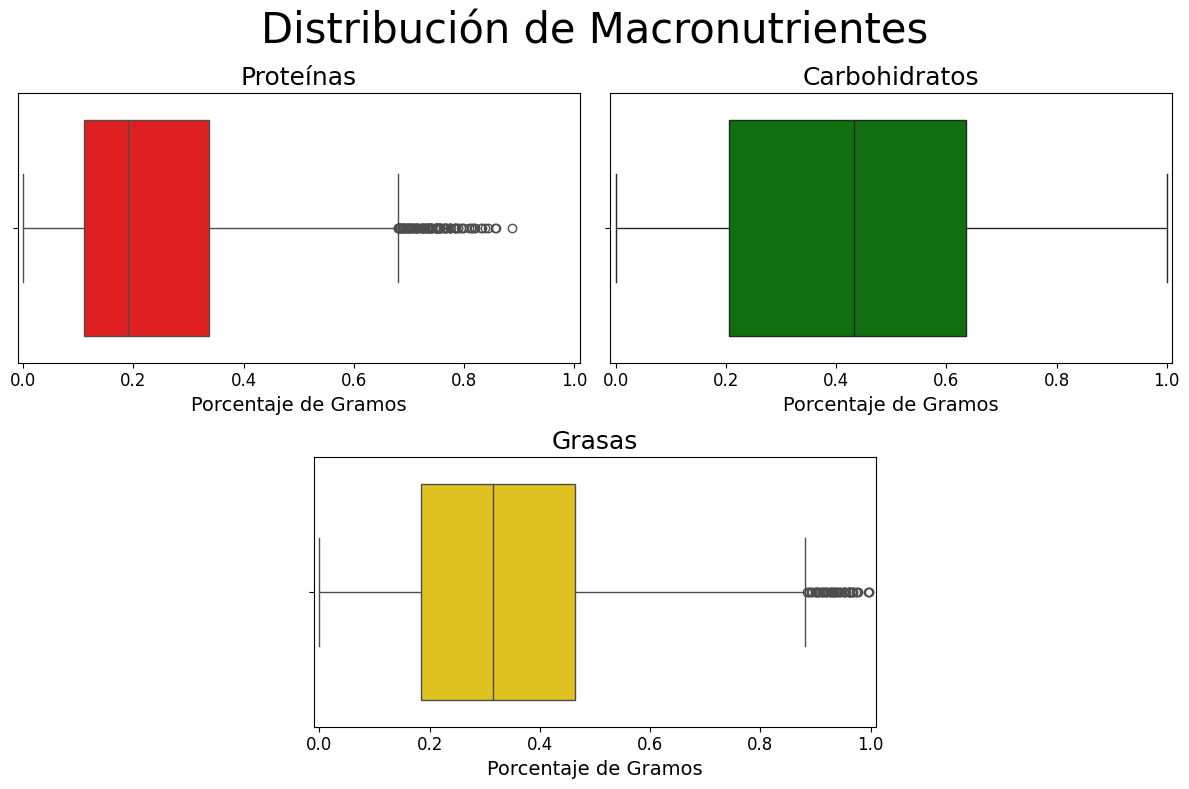

In [49]:
# Plot de la distribución de los macronutrientes

_ = Plot_DistributionMacronutrients(Diets_Dataset)

## 2.2 Estratificación de Valores Cuantitativos

### Medidas de Tendencia Central y Dispersión por Dieta

Por cada dieta, se presentan los valores de las medidas de tendencia central y de dispersión

In [50]:
diet = Diets[0]

print(f'Dieta: {diet}')
SummaryMeasures(Diets_Dataset.query("Diet_type == @diet"),Macronutrients)

Dieta: dash


,Carbs,Protein,Fat
mean,0.549425,0.196241,0.254334
25%,0.331143,0.068931,0.103381
50%,0.555219,0.156626,0.234742
75%,0.757917,0.282629,0.371292
std,0.278850,0.162871,0.194078
min,0.001526,0.000000,0.000000
max,1.000000,0.833467,0.973404
skewness,-0.057984,1.101171,0.732534


In [51]:
diet = Diets[1]

print(f'Dieta: {diet}')
SummaryMeasures(Diets_Dataset.query("Diet_type == @diet"),Macronutrients)

Dieta: keto


,Carbs,Protein,Fat
mean,0.200879,0.301777,0.497344
25%,0.085517,0.158284,0.405354
50%,0.157348,0.302900,0.505751
75%,0.267535,0.409453,0.591887
std,0.160609,0.167027,0.166572
min,0.002060,0.000000,0.000000
max,1.000000,0.856868,0.997940
skewness,1.634945,0.314795,-0.147406


In [52]:
diet = Diets[2]

print(f'Dieta: {diet}')
SummaryMeasures(Diets_Dataset.query("Diet_type == @diet"),Macronutrients)

Dieta: mediterranean


,Carbs,Protein,Fat
mean,0.424493,0.279357,0.296150
25%,0.249955,0.159633,0.180357
50%,0.439382,0.227883,0.268336
75%,0.607531,0.377820,0.390404
std,0.214325,0.162853,0.160783
min,0.006733,0.005036,0.001731
max,0.992746,0.887557,0.968722
skewness,-0.096055,0.955922,0.869493


In [53]:
diet = Diets[3]

print(f'Dieta: {diet}')
SummaryMeasures(Diets_Dataset.query("Diet_type == @diet"),Macronutrients)

Dieta: paleo


,Carbs,Protein,Fat
mean,0.371307,0.249693,0.379000
25%,0.192399,0.102963,0.256579
50%,0.351300,0.205532,0.382447
75%,0.515054,0.375392,0.488116
std,0.221506,0.175031,0.175471
min,0.003612,0.000000,0.001404
max,0.987368,0.858503,0.968835
skewness,0.488656,0.711408,0.312673


In [54]:
diet = Diets[4]

print(f'Dieta: {diet}')
SummaryMeasures(Diets_Dataset.query("Diet_type == @diet"),Macronutrients)

Dieta: vegan


,Carbs,Protein,Fat
mean,0.593968,0.148489,0.257543
25%,0.504070,0.085339,0.142575
50%,0.626246,0.139688,0.231518
75%,0.714679,0.190381,0.344529
std,0.171203,0.086088,0.160277
min,0.000330,0.001921,0.000112
max,0.986872,0.647416,0.994887
skewness,-0.735651,1.439081,1.091809


### Histogramas de Macronutrientes por Dieta

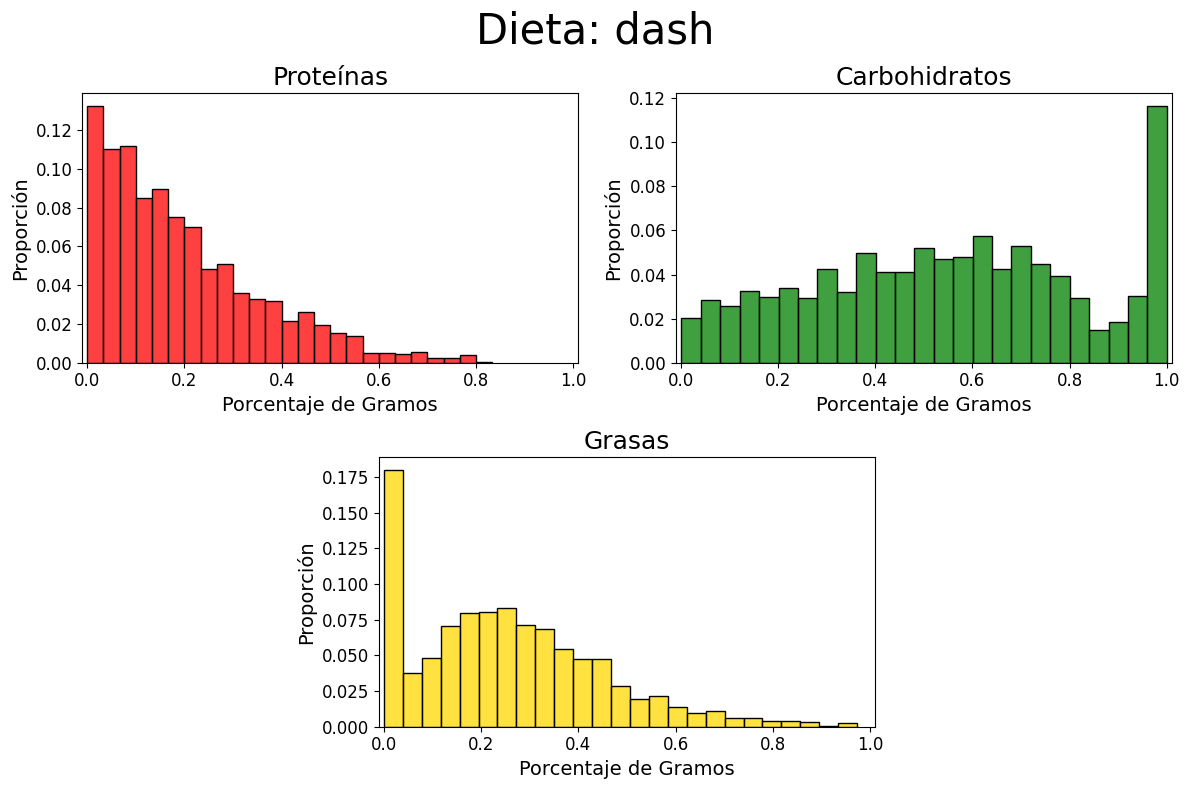

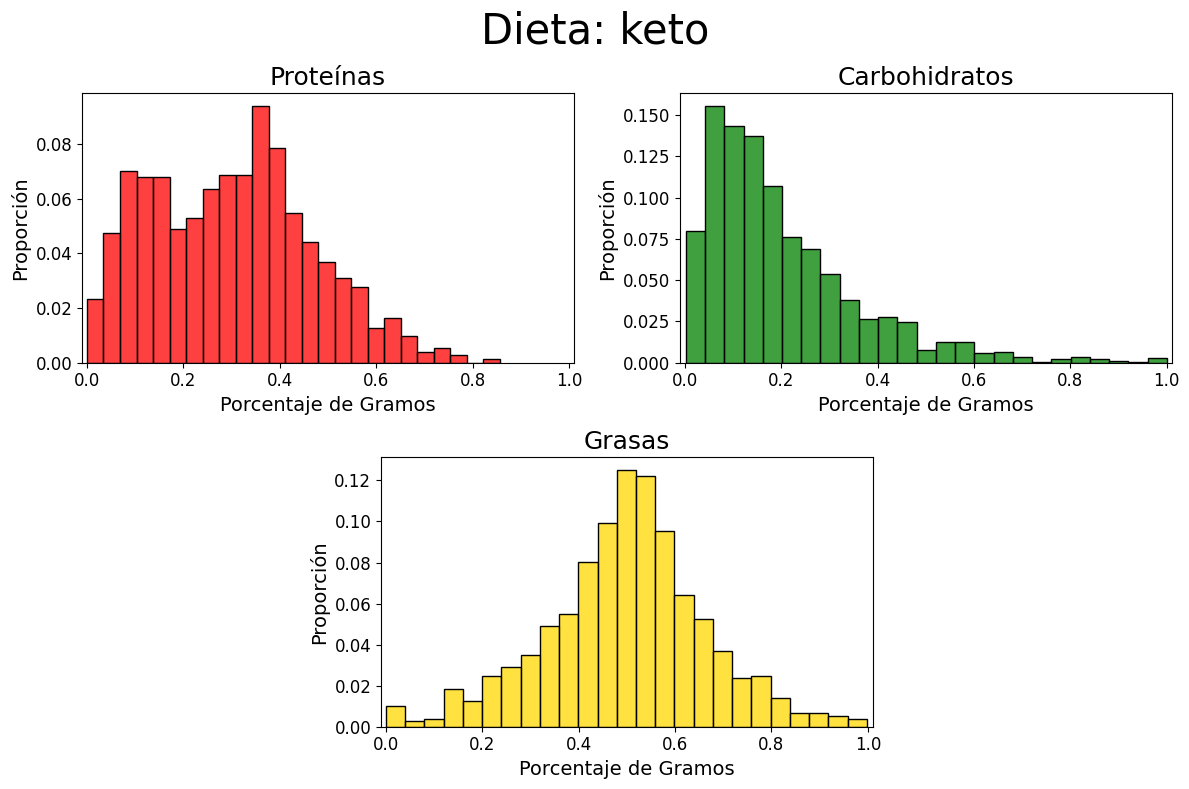

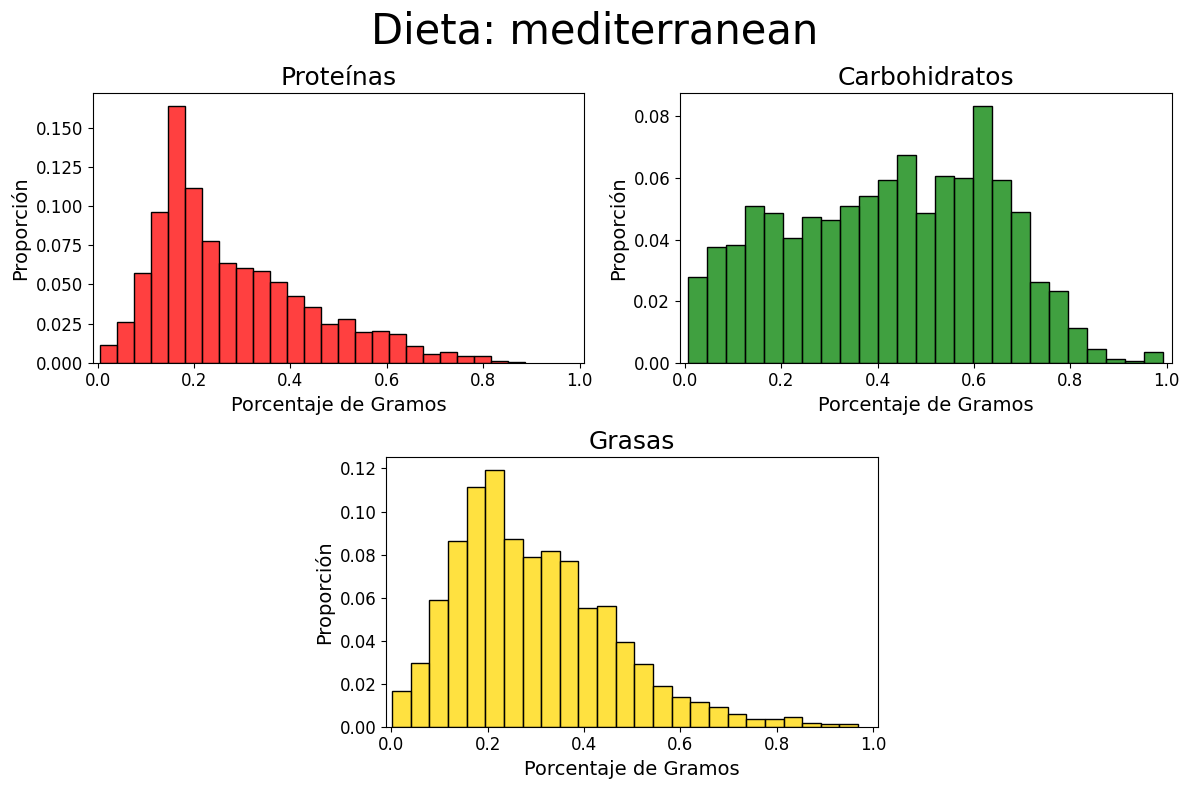

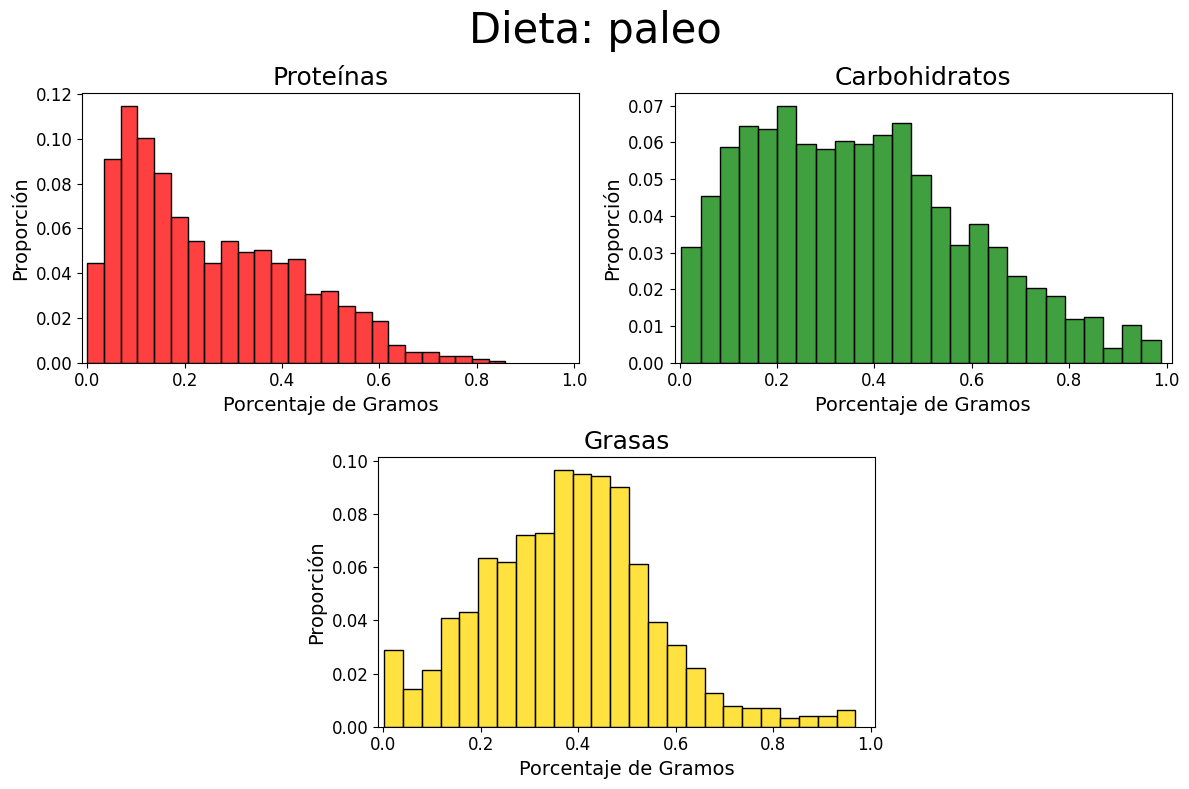

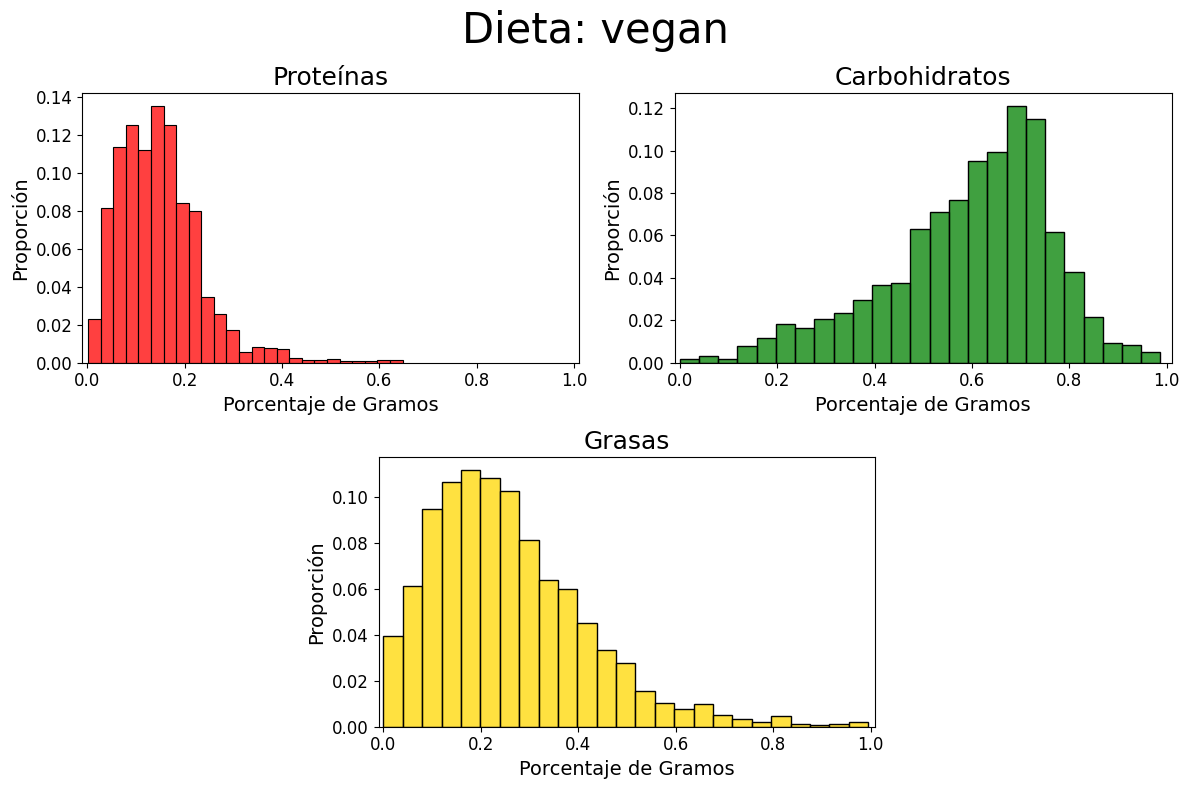

In [55]:
# Histograma de los macronutrientes por dieta

for diet in Diets:
    Plot_MacronutientsByDiet_Histogram(Diets_Dataset,diet)

### Boxplot de Macronutrientes por Dieta

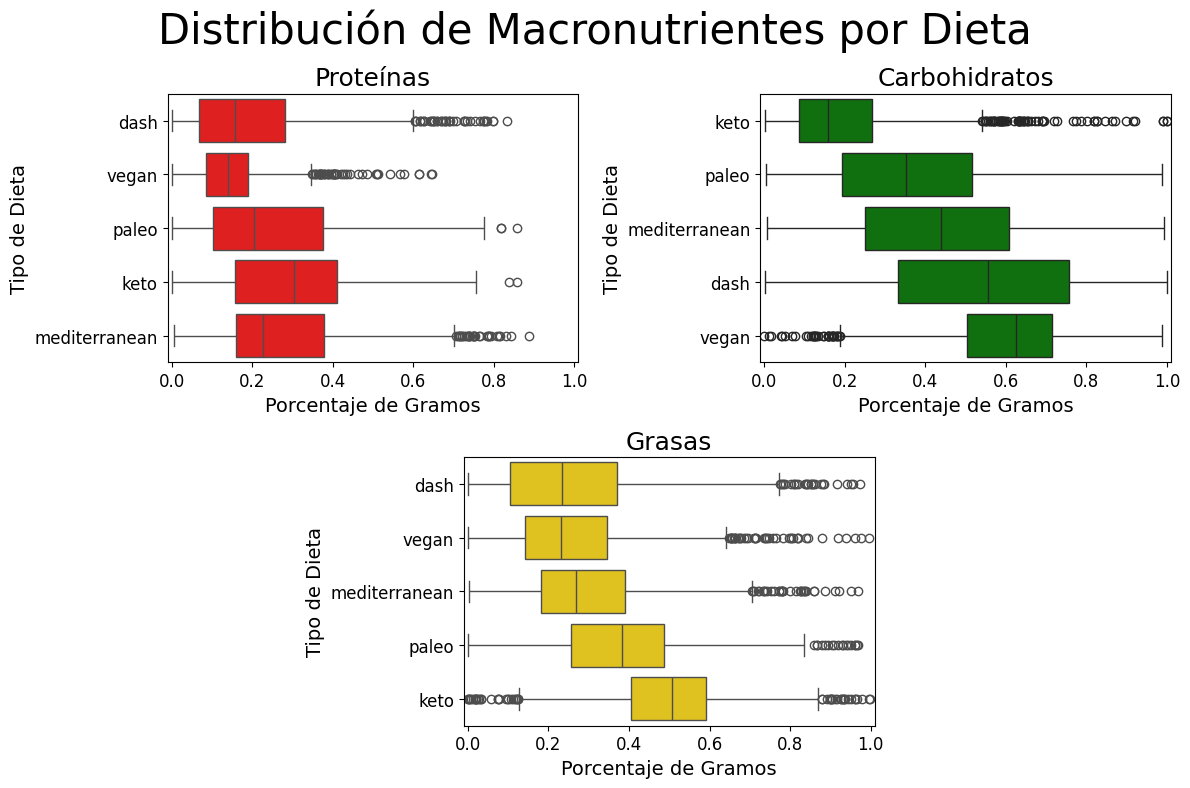

In [78]:
# Boxplot de los macronutrientes por dieta

Plot_MacronutrientsByDiet_Boxplot(Diets_Dataset,Macronutrients)

# 3. Muestreos e Intervalos de Confianza

Como las tres variables cuantitativas tienen el mismo grado de importancia o relevancia, se decide por usar el atributo "Carbs(g)" debido a que no presenta outliers. Y, usando la Regla de Sturges, se consideran 7 clases.

## 3.0 Definición de los Random State

Se definen los estados aleatorios para que lo resultados sean reproducibles

In [57]:
# Random States

random_state_simple = 80
random_state_stratified = 13

## 3.1 Muestreo Aleatorio Simple

Para el muestreo aleatorio simple se escogen de forma aleatoria 50 recetas y solo se consideran sus aportes de macronutrientes.

In [58]:
# Se muestrean de forma aleatoria 50 recetas 

RandomSample = Diets_Dataset.sample(50,random_state=random_state_simple) 

RandomSample.head(10)

,Diet_type,Recipe_name,Cuisine_type,Protein,Carbs,Fat,Total_Macronutrients
3661,keto,Easy Keto Pork and Cabbage Casserole,nordic,0.680332,0.172693,0.146975,1.0
866,paleo,Paleo Peppermint Patties,american,0.054936,0.466505,0.478559,1.0
5425,mediterranean,Mediterranean Pizza,italian,0.163428,0.755348,0.081225,1.0
762,paleo,"Paleo Steak Marinade (Paleo, GF + Sugar Free) ...",american,0.050277,0.470874,0.478849,1.0
2035,vegan,"Eggplant, Mushroom & Pesto Pizza recipes",italian,0.135943,0.632771,0.231286,1.0
3689,keto,Keto Chicken Cordon Bleu Meatballs,french,0.467635,0.070063,0.462302,1.0
5923,mediterranean,Mediterranean Deviled Eggs,mediterranean,0.361921,0.054842,0.583236,1.0
6398,dash,Whipped Butternut Squash and Red Onions,south american,0.063709,0.654810,0.281481,1.0
3850,keto,Spicy Keto Deviled Eggs without Mayo,south american,0.308260,0.161189,0.530552,1.0
1858,vegan,Veggie Kebabs With Vegan Pesto Sauce,american,0.247992,0.238599,0.513409,1.0


In [59]:
# Se calculan las frecuencias relativas, absolutas y acumulada del atributo Carbs(g)

Frequencies_Sample(RandomSample,'Carbs')

Frequencies,Frequency_absolute,Frequency_relative,Frequency_cumulative,Z-Score
Class_mark,,,,
0.071112,6.0,0.12,0.12,-1.519335
0.209217,8.0,0.16,0.28,-0.958601
0.347321,10.0,0.20,0.48,-0.397868
0.485426,8.0,0.16,0.64,0.162865
0.623530,11.0,0.22,0.86,0.723599
0.761635,4.0,0.08,0.94,1.284332
0.899740,3.0,0.06,1.00,1.845065


In [60]:
# Se calculan los Z-Score de los valores del atributo Carbs(g)

ZScores_Sample(RandomSample,'Carbs').head(10)

,Value,ZScore
3661,0.172693,-1.106897
866,0.466505,0.086044
5425,0.755348,1.258804
762,0.470874,0.103781
2035,0.632771,0.761118
3689,0.070063,-1.523593
5923,0.054842,-1.585393
6398,0.654810,0.850600
3850,0.161189,-1.153605
1858,0.238599,-0.839305


In [61]:
# Se calculan las medidas de tendencia central y de dispersión de la muestra

SummaryMeasures(RandomSample,['Carbs'])

,Carbs
mean,0.445313
25%,0.247271
50%,0.465096
75%,0.631106
std,0.246293
min,0.002060
max,0.968792
skewness,0.077583


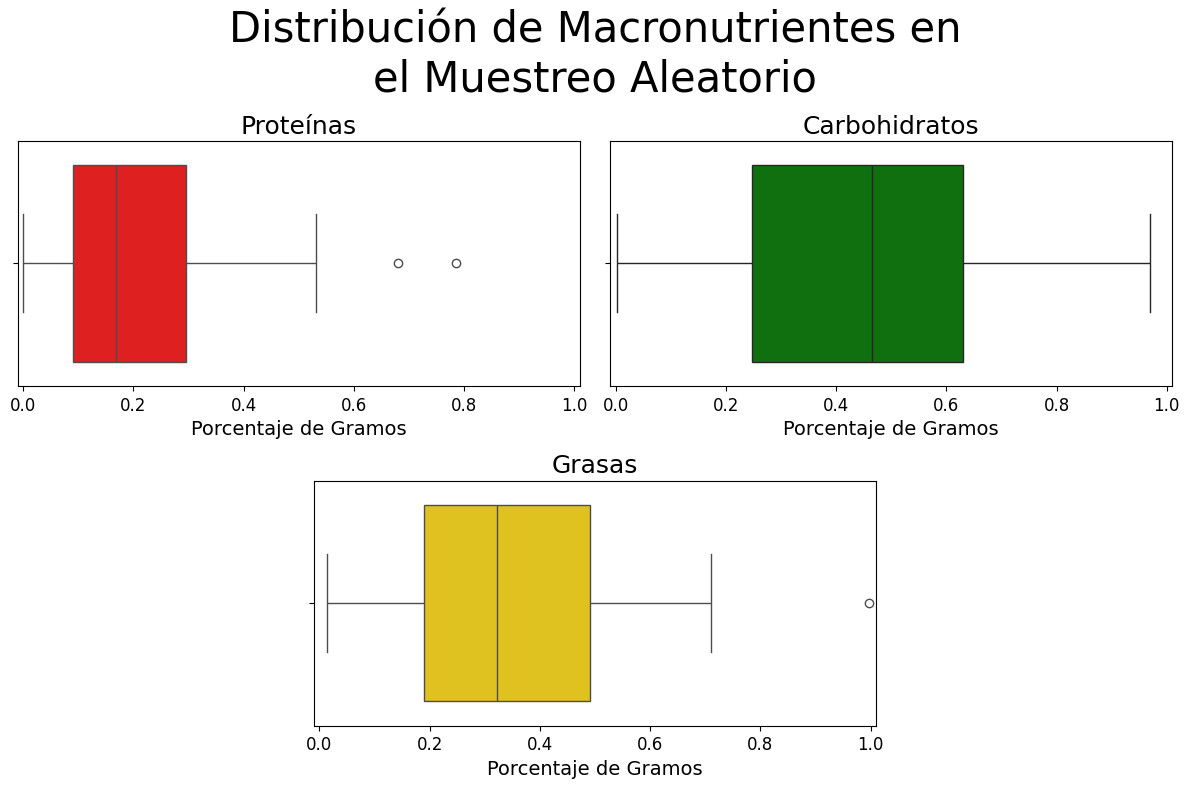

In [62]:
# Plot de la distribución de los macronutrientes en el muestreo

fig = Plot_DistributionMacronutrients(RandomSample)
__SetTitleFig(fig,'Distribución de Macronutrientes en\nel Muestreo Aleatorio')

## 3.2 Muestreo Aleatorio Estratificado

Para el muestreo estratificado se escogen 50 recetas aleatorias de forma que se preserven las proporciones originales en cada estrato respecto al conjunto de datos originales.

In [63]:
# Se calculan el número de recetas por estrato (tipo de dieta)

recipes_by_diet = np.round(50*Diets_Dataset.groupby('Diet_type')['Recipe_name'].count()/Diets_Dataset.shape[0])
recipes_by_diet , np.sum(recipes_by_diet)

(Diet_type
 dash             11.0
 keto             10.0
 mediterranean    11.0
 paleo             8.0
 vegan            10.0
 Name: Recipe_name, dtype: float64,
 np.float64(50.0))

In [64]:
# Se muestrea de forma estratificada 50 recetas

StratifiedSample = []
for diet in Diets:
    recipes_diet = int(recipes_by_diet[diet])
    sample_diet = Diets_Dataset.query("Diet_type == @diet")[Macronutrients].sample(recipes_diet,random_state=random_state_stratified)
    sample_diet['Diet_type'] = diet
    StratifiedSample.append(sample_diet)

StratifiedSample = pd.concat(StratifiedSample)

StratifiedSample.head(10)

,Carbs,Protein,Fat,Diet_type
6164,0.447936,0.372106,0.179957,dash
7156,0.182508,0.600167,0.217325,dash
7295,0.639354,0.035189,0.325458,dash
7023,0.214352,0.425584,0.360064,dash
6792,0.918259,0.063163,0.018577,dash
7511,0.700680,0.134576,0.164744,dash
7379,0.552885,0.332289,0.114826,dash
6794,0.499033,0.082206,0.418761,dash
6494,0.741947,0.105887,0.152166,dash
6128,0.397769,0.295824,0.306407,dash


In [65]:
# Se calculan las frecuencias relativas, absolutas y acumulada del atributo Carbs(g)

Frequencies_Sample(StratifiedSample,'Carbs')

Frequencies,Frequency_absolute,Frequency_relative,Frequency_cumulative,Z-Score
Class_mark,,,,
0.077393,7.0,0.14,0.14,-1.633242
0.206757,6.0,0.12,0.26,-1.078329
0.336121,8.0,0.16,0.42,-0.523416
0.465485,6.0,0.12,0.54,0.031498
0.594849,13.0,0.26,0.80,0.586411
0.724213,8.0,0.16,0.96,1.141324
0.853577,2.0,0.04,1.00,1.696238


In [66]:
# Se calculan los Z-Score de los valores del atributo Carbs(g)

ZScores_Sample(StratifiedSample,'Carbs').head(10)

,Value,ZScore
6164,0.447936,-0.043777
7156,0.182508,-1.182347
7295,0.639354,0.777316
7023,0.214352,-1.045750
6792,0.918259,1.973694
7511,0.700680,1.040379
7379,0.552885,0.406404
6794,0.499033,0.175406
6494,0.741947,1.217397
6128,0.397769,-0.258973


In [67]:
# Se calculan las medidas de tendencia central y de dispersión de la muestra

SummaryMeasures(StratifiedSample,['Carbs'])

,Carbs
mean,0.458142
25%,0.258305
50%,0.501985
75%,0.650737
std,0.233125
min,0.012711
max,0.918259
skewness,-0.226386


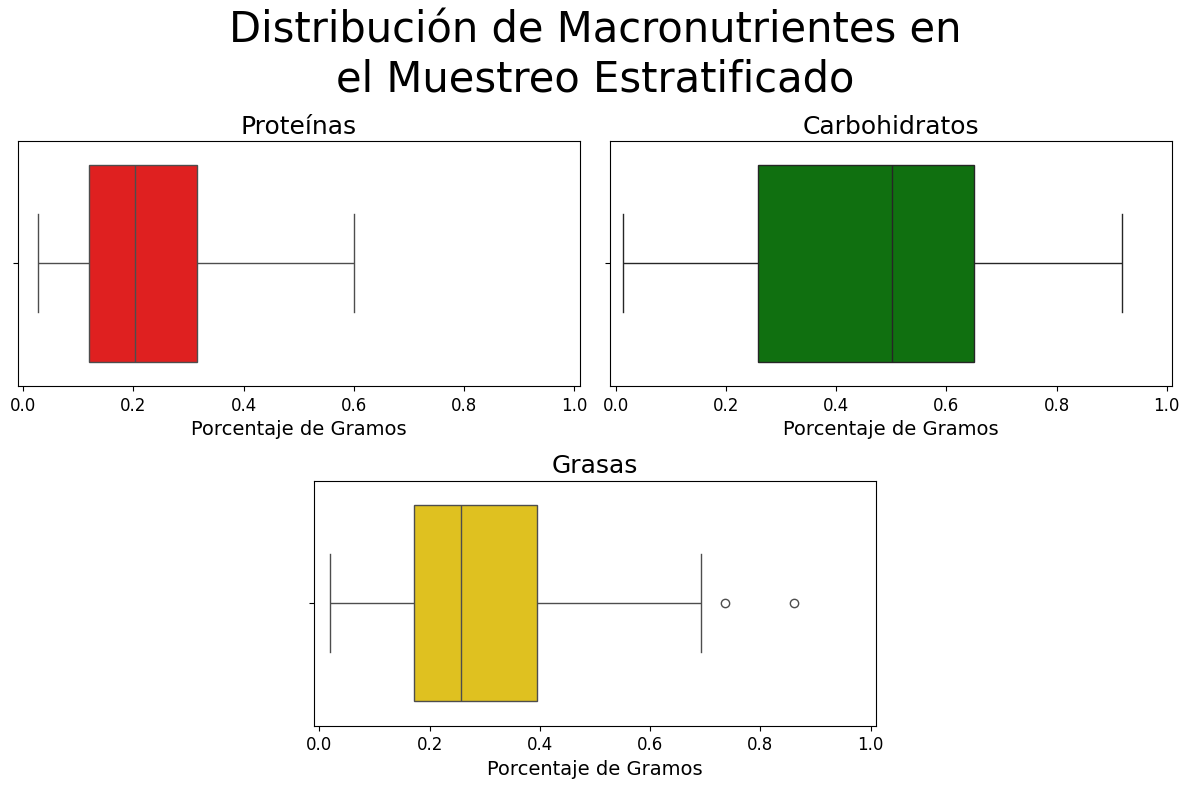

In [68]:
# Plot de la distribución de los macronutrientes en el muestreo

fig = Plot_DistributionMacronutrients(StratifiedSample)
__SetTitleFig(fig,'Distribución de Macronutrientes en\nel Muestreo Estratificado')

## 3.3 Intervalos de Confianza

In [69]:
# Definición de los Niveles de Confianza a usar

ConfidenceLevels = [0.85,0.95,0.99]

In [70]:
# Intervalos de Confianza para la Media Poblacional usando el Muestreo Aleatorio

Show_ConfidenceIntervals(RandomSample['Carbs'],ConfidenceLevels,ConfidenceIntervalPopulationMean)

,Lower Bound,Upper Bound
Confidence Level,,
0.85,0.395173,0.495454
0.95,0.377046,0.513581
0.99,0.355595,0.535032


In [71]:
# Intervalos de Confianza para la Media Poblacional usando el Muestreo Estratificado

Show_ConfidenceIntervals(StratifiedSample['Carbs'],ConfidenceLevels,ConfidenceIntervalPopulationMean)

,Lower Bound,Upper Bound
Confidence Level,,
0.85,0.410682,0.505602
0.95,0.393524,0.522760
0.99,0.373220,0.543064
